# Pipeline
This notebook runs a 1D CNN on ECG data from [The 4th China Physiological Signal Challenge 2021](https://physionet.org/content/cpsc2021/1.0.0/).

The output of this notebook includes accuracy metrics on chunk-level classification of ECG Data, as well as AF Burden Predictions and MAE.

To run this notebook, install the necessary requirements from the requirements.txt file, and download the data from the link above. Modify the DATA_PATH variable to poin to the data.

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import wfdb
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


pd.set_option("display.max_rows", None, "display.max_columns", None)
%matplotlib inline

In [ ]:
DATA_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data"

## Data Preprocessing

In [ ]:
def load_record(sample_path):
    
    '''  returns signal, global label, local labels ''' 
    
    sig, fields = wfdb.rdsamp(sample_path)
    ann_ref = wfdb.rdann(sample_path, 'atr')
    
    label = fields['comments'][0]
    fs = fields['fs']
    sig = sig[:, 1]
    length = len(sig)
    
    #print("Signal: ", sig)
    #print("\nLabel: ", label)
    #print(wfdb.rdsamp(sample_path))
    #print("\n\n", wfdb.rdann(sample_path, 'atr').aux_note)
    
    beat_loc = np.array(ann_ref.sample) # r-peak locations
    ann_note = np.array(ann_ref.aux_note) # rhythm change flag
    
    return sig, length, fs, label, ann_note, beat_loc


In [ ]:
def normalize(signal):

    values = signal
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    normalized = [item for sublist in normalized for item in sublist]
    #print(normalized)

    return normalized

In [ ]:
def chunks(lst, n):
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [ ]:
def build_chunked_input(seconds):
        
    ''' Builds chunked signal input  '''
        
    test_set = open(os.path.join(DATA_PATH, 'RECORDS'), 'r').read().splitlines()

    input_df = pd.DataFrame(columns=["Sequence Number", "Chunked Signal", "Sequence Label", 
                                     "Chunked Label", "Signal Length", "AF Burden"])
      
    for i, sample in enumerate(test_set):
        
        #print("\n\n\n", sample)
        print(i, end='\r')
        sample_path = os.path.join(DATA_PATH, sample)
        sig, sig_len, fs, label, label_arr, beat_loc = load_record(sample_path)
        
        r_peaks = beat_loc
        #qrs_peaks = (qrs_detect(sig, fs)).astype(int)
        #r_peaks = qrs_peaks
        chunksize = seconds*200
        
        #print(sig)
        #print("\n\nr_peaks: ", r_peaks, len(r_peaks))
        #print("\nqrs_detect: ", qrs_peaks, len(qrs_peaks))
        
        sig = normalize(sig)
        
        ## Calculate exact AF ranges in sequence Label arr acts as an index 
        ## for which peaks in r_peaks are afib
           
        af_ranges = []
        af_range = []
                
        for li, l in enumerate(label_arr):
            if l == "(AFIB" or l == "(AFL":
                printlabelarr = True
                start = r_peaks[li] #r_peaks[min(len(r_peaks)-1, li)]
                af_range.append(start)
            if l == "(N":
                stop = r_peaks[li] #r_peaks[min(len(r_peaks)-1, li)]
                af_range.append(stop)
                af_ranges.append(af_range)
                af_range = []
        
        #print("\n", af_ranges)
        
        ## Label sections of signal as AF/non AF
        loc_labels = [0]*sig_len
        for rng in af_ranges:
            start = rng[0]
            stop = rng[1]
            loc_labels[ start : stop ] = [1] * (stop-start) 
        
        ## Break signal and label sequences down to n-second chunks
        chunked_sig = chunks(sig, chunksize)[:-1]
        chunked_label = chunks(loc_labels, chunksize)[:-1]
        
        ## Calculate AF Burden per sequence based on AF ranges
        burden=0
        for rng in af_ranges:
            burden+=rng[1]-rng[0] 
        burden = burden/sig_len  

        input_df.at[i, 'Sequence Number'] = i
        input_df.at[i, 'Chunked Signal'] = chunked_sig
        input_df.at[i, 'Chunked Label'] = chunked_label
        input_df.at[i, 'Signal Length'] = sig_len
        input_df.at[i, 'Sequence Label'] = label
        input_df.at[i, 'AF Burden'] = burden
        
    ## Convert from sequence-level df into chunk-level df
    input_df = input_df.explode(["Chunked Signal", "Chunked Label"])
    input_df.dropna(subset=['Chunked Label'], inplace=True)

    ## Assign most common granular label as overall chunk label
    input_df["Chunked Label"] = input_df["Chunked Label"].apply(lambda x: Counter(x).most_common(1)[0][0])
    
    return input_df


In [ ]:
seconds=10
chunk_df = build_chunked_input(seconds)
chunk_df.dropna(inplace=True)
chunk_df.info(null_counts=True)

In [ ]:
%%time
chunk_df = chunk_df.reset_index()
chunk_df.to_feather("./chunk_df_1436_10")

## Model

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, MaxPooling1D
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics

In [3]:
%%time
chunk_df = pd.read_feather("./chunk_df_1436_10", columns=None, use_threads=True)

CPU times: user 3.26 s, sys: 7.3 s, total: 10.6 s
Wall time: 14.8 s


In [4]:
## Split into train and test data (70-30 split). Ensure record chunks are not split between train and test

cutoff = int(.7*max(chunk_df['Sequence Number']))
print("Cutoff: ", cutoff)
train_df = chunk_df[chunk_df['Sequence Number'] < cutoff]
test_df = chunk_df[chunk_df['Sequence Number'] >= cutoff]

X_train = pd.DataFrame(train_df['Chunked Signal'].tolist())
X_test = pd.DataFrame(test_df['Chunked Signal'].tolist())

y_train = pd.DataFrame(train_df['Chunked Label'].tolist())
y_test = pd.DataFrame(test_df['Chunked Label'].tolist())

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Cutoff:  996


In [9]:
%%time

batch = 16
epochs = 2
shape = np.size(X_train, 1)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (shape,1)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) 
model.summary()
model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy'])

X_train = np.expand_dims(X_train, 2)
#X_test = np.expand_dims(X_test, 2)


model.fit(X_train,y_train, batch_size = batch, epochs = epochs)

2021-12-12 21:20:29.832760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000, 100)         200       
                                                                 
 conv1d (Conv1D)             (None, 1991, 100)         100100    
                                                                 
 conv1d_1 (Conv1D)           (None, 1982, 100)         100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 660, 100)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 651, 160)          160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 642, 160)          256160    
                                                        

In [10]:
%%time 

X_test = np.expand_dims(X_test, 2)
score = model.evaluate(X_test, y_test, batch_size = batch)
score

2270/2270 [==============================] - 230s 101ms/step - loss: 0.4611 - accuracy: 0.9101
CPU times: user 24min 7s, sys: 31.8 s, total: 24min 38s
Wall time: 3min 52s


[0.461062490940094, 0.9101123809814453]

In [11]:
## Save Model & Weights

try:
    # serialize model to JSON
    model_json = model.to_json()
    with open("full_model_1400_10.json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights("full_model_1400_10.h5")
    print("Saved model to disk")
except:
    print("Model failed to save")

Saved model to disk


## Evaluation

In [12]:
%%time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error


threshold = 0.5

y_pred = model.predict(X_test, batch_size = batch)
y_test['y_pred'] = y_pred[:,0] > threshold
if "index" in y_test.columns: y_test.drop('index', inplace=True)
y_test.columns=['y_true', 'y_pred']
y_test['y_pred'] = y_test['y_pred'].astype(float)

cm = confusion_matrix(y_test['y_true'], y_test['y_pred'])

print("\n Accuracy: ", score[1])
print("\n Loss: ", score[0])
print("\n F1 score: ", f1_score(y_test['y_true'], y_test['y_pred'], average='macro'))
print("\n Confusion Matrix: \n", cm)


 Accuracy:  0.9101123809814453

 Loss:  0.461062490940094

 F1 score:  0.9100525955042035

 Confusion Matrix: 
 [[16056  2020]
 [ 1244 16992]]
CPU times: user 33min 51s, sys: 56.3 s, total: 34min 48s
Wall time: 13min


In [13]:
## Append predictions to test dataset

test_df.reset_index(inplace=True)
y_test.reset_index(inplace=True)
chunked_test = pd.concat([test_df, y_test], axis=1)

In [16]:
## Condense dataset back to the sequence level, calculate Predicted AF Burden

chunked_test['y_pred_2'] = chunked_test['y_pred']

seq_test = (chunked_test.drop(columns=['Chunked Signal'])
      .groupby(['Sequence Number', 'Sequence Label', 'AF Burden', 'Signal Length'])
      .agg({'Chunked Label': lambda x: x.tolist() , 'y_pred': lambda x: x.tolist(), 'y_pred_2':'sum', })
      .rename({'y_pred_2' : 'AF Episodes'},axis=1)
      .reset_index())

seq_test['Predicted AF Burden'] = (seq_test['AF Episodes']*seconds*200) / seq_test['Signal Length']

In [20]:
## Calculate MAE for AF Burden Predications

burden_mae = mean_absolute_error(seq_test['AF Burden'],seq_test['Predicted AF Burden'])
burden_mae

0.12376731011513718

Text(0, 0.5, 'Predicted Burden')

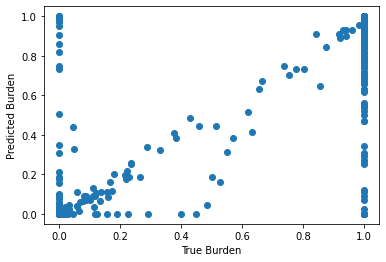

In [19]:
## Visualize AF Burden

plt.scatter(seq_test['AF Burden'], seq_test['Predicted AF Burden'])
plt.xlabel("True Burden")
plt.ylabel("Predicted Burden")

In [21]:
seq_test.to_pickle("final_test_10SEC.pkl")